In [1]:
import json
import pandas as pd
import seaborn as sns
with open('match_2.json', 'r') as json_file:
    data = json.load(json_file)

In [2]:
match_1 = pd.DataFrame(data)

In [3]:
match_1

,label,norm
0,no action,"[104.42423889328715, 87.63989343949717, 128.52..."
1,run,"[108.03112639951678, 92.57566083451651, 81.303..."
2,pass,"[17.837163554142162, 39.435455203974186, 51.64..."
3,rest,"[21.91843920469922, 18.11914155706377, 21.7137..."
4,walk,"[20.86063916182152, 17.8097748446304, 14.35537..."
...,...,...
608,walk,"[23.337305769963503, 20.210987911153104, 25.06..."
609,walk,"[22.470322813933603, 22.552427730975246, 23.84..."
610,walk,"[43.833612705797144, 46.18045998580312, 37.492..."
611,walk,"[30.927599255773355, 31.26358258808756, 28.286..."


In [78]:
match_1['label'].value_counts()

run          343
walk         190
dribble       36
shot          12
tackle        11
rest          10
pass           8
no action      2
cross          1
Name: label, dtype: int64

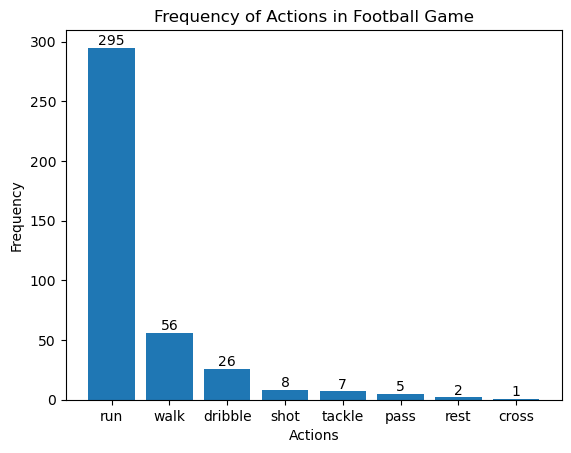

In [363]:
import matplotlib.pyplot as plt

frequencies = data['label'].value_counts().reset_index()
frequencies.columns = ['Action', 'Frequency']
plt.bar(frequencies['Action'], frequencies['Frequency'])
plt.xlabel('Actions')
plt.ylabel('Frequency')
plt.title('Frequency of Actions in Football Game')
for index, row in frequencies.iterrows():
    plt.text(row['Action'], row['Frequency'], str(row['Frequency']), ha='center', va='bottom')

plt.show()



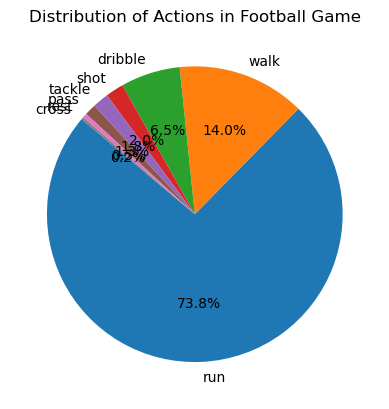

In [324]:
labels = frequencies['Action']
sizes = frequencies['Frequency']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Actions in Football Game')

plt.show()


In [81]:
walk = match_1[match_1['label']=='walk'].reset_index(drop=True)

In [82]:
walk['len'] = walk['norm'].apply(lambda x: len(x))


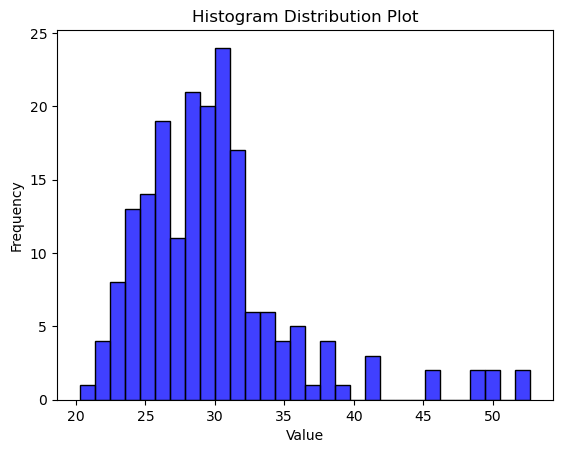

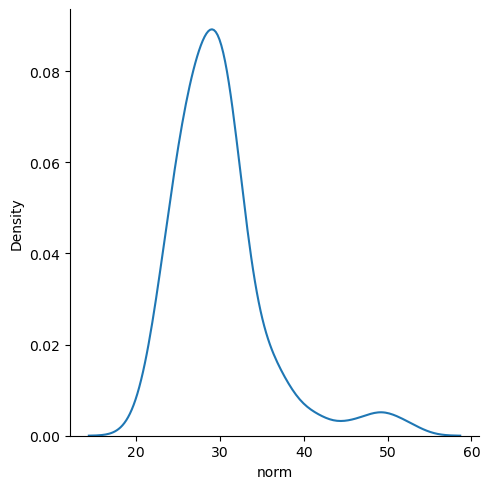

In [84]:
sns.histplot(walk['norm'].apply(lambda x: sum(x)/len(x)), bins=30, kde=False, color='blue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Distribution Plot')
sns.displot(walk['norm'].apply(lambda x: sum(x)/len(x)), kind="kde")


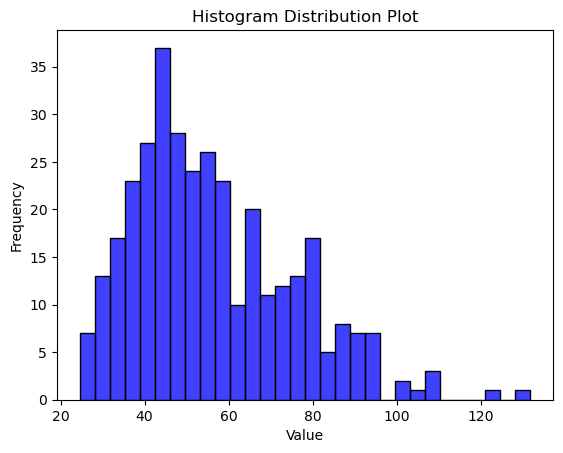

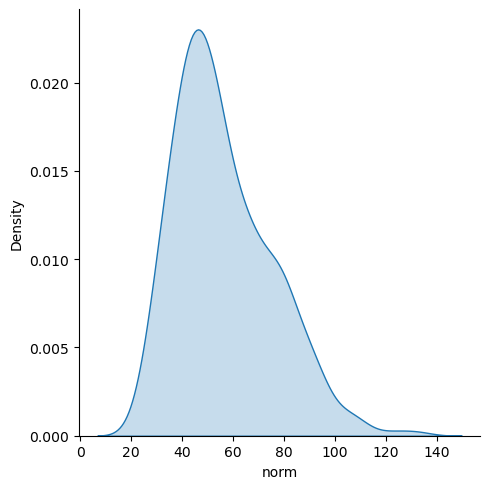

In [92]:
run = match_1[match_1['label']=='run'].reset_index(drop=True)
run['len'] = run['norm'].apply(lambda x: len(x))


sns.histplot(run['norm'].apply(lambda x: sum(x)/len(x)), bins=30, kde=False, color='blue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Distribution Plot')
sns.displot(run['norm'].apply(lambda x: sum(x)/len(x)), kind="kde",fill=True)

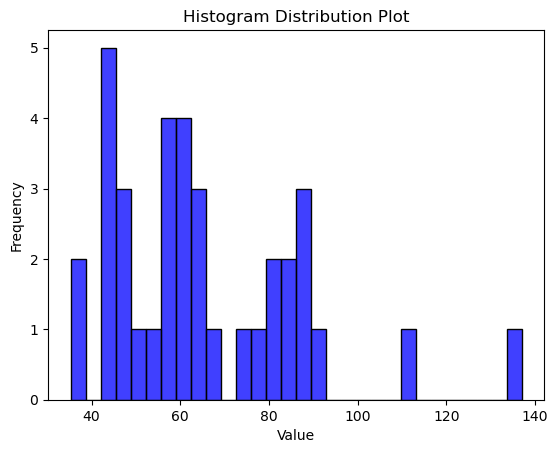

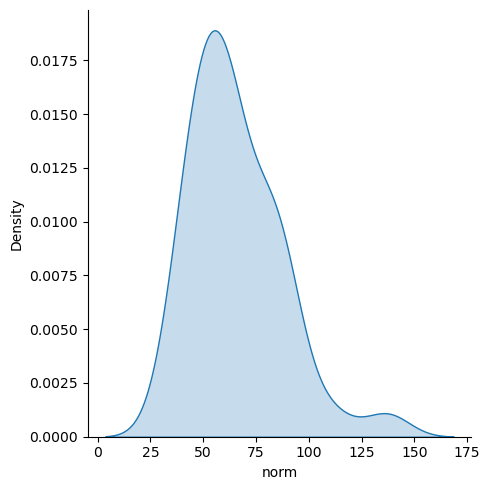

In [91]:
dribble = match_1[match_1['label']=='dribble'].reset_index(drop=True)
dribble['len'] = dribble['norm'].apply(lambda x: len(x))


sns.histplot(dribble['norm'].apply(lambda x: sum(x)/len(x)), bins=30, kde=False, color='blue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Distribution Plot')
sns.displot(dribble['norm'].apply(lambda x: sum(x)/len(x)), kind="kde", fill=True)

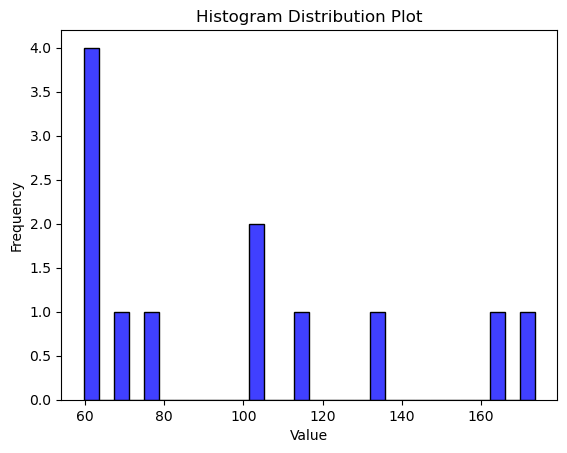

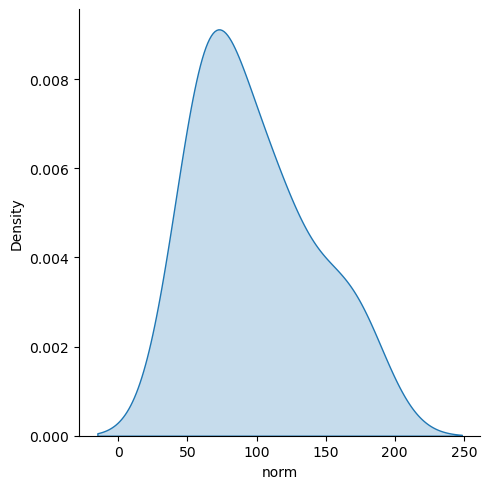

In [90]:
shot = match_1[match_1['label']=='shot'].reset_index(drop=True)
shot['len'] = shot['norm'].apply(lambda x: len(x))


sns.histplot(shot['norm'].apply(lambda x: sum(x)/len(x)), bins=30, kde=False, color='blue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram Distribution Plot')
sns.displot(shot['norm'].apply(lambda x: sum(x)/len(x)), kind="kde", fill=True)

In [271]:
data = match_1

In [272]:
data = data[data['norm'].apply(lambda x: len(x)) < 50]

In [273]:
data = data[data['norm'].apply(lambda x: len(x)) > 10]

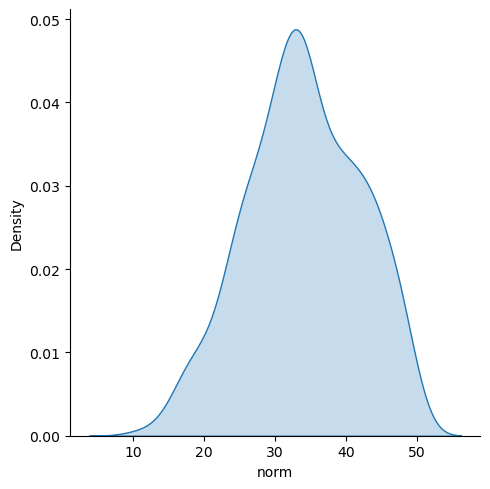

In [274]:
sns.displot(data['norm'].apply(lambda x: len(x)), kind="kde", fill=True)

In [345]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform

class KnnDtw(object):
    def __init__(self, n_neighbors=5, max_warping_window=np.inf, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        self.x = x
        self.l = l
        
        
    def _dtw_distance(self, ts_a, ts_b, d=lambda x, y: abs(x - y)):
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = np.inf * np.ones((M, N))

        cost[0, 0] = d(ts_a[0], ts_b[0])
        
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window), min(N, i + self.max_warping_window)):
                choices = cost[i-1, j-1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        x_s = np.shape(x)
        y_s = np.shape(y)
        dm = np.zeros((x_s[0], y_s[0])) 

        for i in range(0, x_s[0]):
            for j in range(0, y_s[0]):
                dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step], y[j, ::self.subsample_step])
        
        return dm
        
    def predict(self, x):
        dm = self._dist_matrix(x, self.x)
        knn_idx = dm.argsort()[:, :self.n_neighbors]
        knn_labels = self.l[knn_idx]
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1] / self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()


In [342]:
a = np.array([1,4,5,10,9,3,2,6,8,4])
b = np.array([1,7,3,4,1,10,5,4,7,4])
DTW(a, b)

15.0

In [343]:
from dtaidistance import dtw
s1 = [1,4,5,10,9,3,2,6,8,4]
s2 = [1,7,3,4,1,10,5,4,7,4]
distance = dtw.distance(s1, s2)
print(distance)


6.082762530298219


In [346]:
X = data['norm']
y = data['label']

from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


In [347]:
x_test_padded = np.array([np.pad(ts, (0, max(len(item) for item in x_test) - len(ts))) for ts in x_test])
x_train_padded = np.array([np.pad(ts, (0, max(len(item) for item in x_train) - len(ts))) for ts in x_train])
y_test_padded = np.array([np.pad(ts, (0, max(len(item) for item in y_test) - len(ts))) for ts in y_test])
y_train_padded = np.array([np.pad(ts, (0, max(len(item) for item in y_train) - len(ts))) for ts in y_train])

In [278]:
# min(len(item) for item in x_train)

16

In [348]:
x_train = np.array(x_train_padded)
y_train = np.array(y_train_padded)
x_test = np.array(x_test_padded)
y_test = np.array(y_test_padded)

In [359]:
m = KnnDtw(n_neighbors=5, max_warping_window=10)
m.fit(x_train, y_train)


In [360]:
label, proba = m.predict(x_test)

C:\Users\Amine\AppData\Local\Temp\ipykernel_18508\2170577471.py:53: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode_data = mode(knn_labels, axis=1)
C:\Users\Amine\AppData\Local\Temp\ipykernel_18508\2170577471.py:53: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  mode_data = mode(knn_labels, axis=1)


In [361]:
label, proba

(array(['run', 'run', 'run', 'run', 'run', 'run', 'run', 'walk', 'run',
        'run', 'run', 'run', 'run', 'walk', 'walk', 'run', 'run', 'run',
        'walk', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'walk',
        'run', 'run', 'walk', 'run', 'run', 'run', 'run', 'walk', 'run',
        'walk', 'run', 'run', 'run', 'dribble', 'run', 'run', 'walk',
        'run', 'run', 'run', 'run', 'run', 'run', 'walk', 'run', 'run',
        'run', 'run', 'run', 'walk', 'walk', 'run', 'run', 'run', 'run',
        'run', 'run', 'run', 'walk', 'run', 'run', 'run', 'run', 'run',
        'run', 'run', 'walk', 'run', 'run', 'run', 'walk', 'run', 'run',
        'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run',
        'run', 'run', 'run', 'run', 'run', 'run', 'walk', 'run', 'run',
        'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run',
        'run', 'run', 'run', 'walk', 'run', 'run', 'run', 'walk', 'run',
        'run', 'run', 'run', 'run', 'run', 'run', 'run', 'run'

In [362]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Use the print function as a function, not a variable
print(classification_report(label, y_test))




              precision    recall  f1-score   support

       cross       0.00      0.00      0.00         0
     dribble       0.00      0.00      0.00         1
         run       0.92      0.81      0.86       111
        shot       0.00      0.00      0.00         0
      tackle       0.00      0.00      0.00         0
        walk       0.63      0.60      0.62        20

    accuracy                           0.77       132
   macro avg       0.26      0.24      0.25       132
weighted avg       0.87      0.77      0.82       132



c:\Users\Amine\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Amine\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Amine\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [320]:
clf.fit(x_train, y_train)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


c:\Users\Amine\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


ValueError: 
All the 9 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
TypeError: float() argument must be a string or a number, not 'list'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "c:\Users\Amine\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Amine\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py", line 215, in fit
    return self._fit(X, y)
  File "c:\Users\Amine\anaconda3\lib\site-packages\sklearn\neighbors\_base.py", line 454, in _fit
    X, y = self._validate_data(
  File "c:\Users\Amine\anaconda3\lib\site-packages\sklearn\base.py", line 565, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "c:\Users\Amine\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 1106, in check_X_y
    X = check_array(
  File "c:\Users\Amine\anaconda3\lib\site-packages\sklearn\utils\validation.py", line 879, in check_array
    array = _asarray_with_order(array, order=order, dtype=dtype, xp=xp)
  File "c:\Users\Amine\anaconda3\lib\site-packages\sklearn\utils\_array_api.py", line 185, in _asarray_with_order
    array = numpy.asarray(array, order=order, dtype=dtype)
  File "c:\Users\Amine\anaconda3\lib\site-packages\pandas\core\series.py", line 857, in __array__
    return np.asarray(self._values, dtype)
ValueError: setting an array element with a sequence.


In [310]:
x_train

array([[15.50318714, 16.09789275, 15.63603616, ...,  0.        ,
         0.        ,  0.        ],
       [55.95682129, 58.16431532, 54.70970168, ...,  0.        ,
         0.        ,  0.        ],
       [27.14934317, 21.26517555, 44.16793914, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [47.71838792, 43.64336161, 77.13093522, ...,  0.        ,
         0.        ,  0.        ],
       [57.19328257, 69.65586523, 81.22471905, ...,  0.        ,
         0.        ,  0.        ],
       [43.05248647, 47.8259273 , 79.02274422, ...,  0.        ,
         0.        ,  0.        ]])

In [ ]:
#evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))